<a href="https://colab.research.google.com/github/jonsPavel/APS-info/blob/master/CNN_yelp_polarity_conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Определение тональности текстов отзывов на сайте [YELP](https://www.yelp.com/dataset) одномерной сверточной нейросетью

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Среда выполнения -> Сменить среду выполнение -> Аппаратный ускоритель -> GPU).



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
num_words = 10000
max_review_len = 100

## Загрузка набора данных

In [ ]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2020-10-13 13:52:31--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2020-10-13 13:52:31--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2e06c808732a0d4a432db3876.dl.dropboxusercontent.com/cd/0/get/BBMUm66lOshNRvkWUea5wzIdKh5QGHX3SqDFdvL-uYaoQ-EDKXxExw5wkfxvHHYZE-w5go1wKORlvMX0XNjANRNFc2iHDtOc0DS4-mqJACTijGRElxQhSLL7W_3YXUWKEns/file?dl=1# [following]
--2020-10-13 13:52:32--  https://uce2e06c808732a0d4a432db3876.dl.dropboxusercontent.com/cd/0/get/BBMUm66lOshNRvkWUea5wzIdKh5QGHX3SqDFdvL-uYaoQ-EDKXxExw5wkfxvH

In [ ]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


## Просматриваем данные

In [ ]:
!cat yelp_review_polarity_csv/readme.txt

In [ ]:
!head yelp_review_polarity_csv/train.csv

In [ ]:
!head yelp_review_polarity_csv/test.csv

In [ ]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


Выделяем данные для обучения

In [ ]:
reviews = train['Review']

In [ ]:
reviews[:5]

Выделяем правильные ответы

In [ ]:
y_train = train['Class'] - 1

In [ ]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

## Токенизация текста

In [ ]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на отзывах Yelp

In [ ]:
tokenizer.fit_on_texts(reviews)

Просматриваем словарь токенизатора

In [ ]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'was': 6,
 'of': 7,
 'it': 8,
 'for': 9,
 'in': 10,
 'is': 11,
 'n': 12,
 'that': 13,
 'my': 14,
 'we': 15,
 'this': 16,
 'but': 17,
 'with': 18,
 'they': 19,
 'you': 20,
 'on': 21,
 'not': 22,
 'have': 23,
 'had': 24,
 'at': 25,
 'were': 26,
 'so': 27,
 'are': 28,
 'food': 29,
 'be': 30,
 'place': 31,
 'me': 32,
 'there': 33,
 'good': 34,
 'as': 35,
 'out': 36,
 'all': 37,
 'like': 38,
 'if': 39,
 'just': 40,
 'our': 41,
 'very': 42,
 'get': 43,
 'one': 44,
 'here': 45,
 'time': 46,
 'when': 47,
 'up': 48,
 'or': 49,
 'from': 50,
 'great': 51,
 'service': 52,
 'would': 53,
 'back': 54,
 'their': 55,
 'about': 56,
 'no': 57,
 'go': 58,
 'an': 59,
 'what': 60,
 'really': 61,
 'he': 62,
 "it's": 63,
 'she': 64,
 'which': 65,
 'will': 66,
 'some': 67,
 'only': 68,
 'been': 69,
 'us': 70,
 'your': 71,
 'because': 72,
 'more': 73,
 'even': 74,
 'can': 75,
 'them': 76,
 'by': 77,
 "don't": 78,
 'got': 79,
 'other': 80,
 'after': 81,
 'do': 8

Преобразуем отзывы Yelp в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)

Просматриваем отзывы в числовом представлении

In [ ]:
index = 100
print(reviews[index])
print(sequences[index])

In [ ]:
tokenizer.word_index['in']

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [ ]:
x_train[:5]

array([[   7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,   10,
        2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,  803,
          88, 3812,    1,  446,    8,  392,  841,  115,  360,    7, 4136,
        1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,   49,
        1687,    4,  418,   18,    8,    3,   23,  563,  178,   16,  460,
          18,  189,   80, 3128,    2,    3,   40,   78,   43,    8,   20,
          23,  644, 1343,   20,   23, 3252,   18, 2921,  637,  227,  430,
         476, 4312,    1,  446,   63,    2,   22,  215,    1,   63,   18,
        2269,   13,    3,  249,   13,    3,   23,    4,  163,  939,  115,
         237],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   69,  116,
           4,  939,    9,   94,  201,  274,    3,  142,    3,    6,   44,
           7,  177, 2084, 3252,   47,   62,  422,   25, 1334,   69,   51,
          94,    1,  274,    2,   11,   61,   37,   56,    1,  219, 1403,
           8,   11,   7

## Создаем нейронную сеть

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 250)           80250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 752,507
Trainable params: 752,507
Non-trainable params: 0
__________________________________________________

## Обучаем нейронную сеть

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/4
3938/3938 [==============================] - 52s 13ms/step - loss: 0.1862 - accuracy: 0.9240 - val_loss: 0.1226 - val_accuracy: 0.9539
Epoch 2/4
3938/3938 [==============================] - 53s 13ms/step - loss: 0.1232 - accuracy: 0.9538 - val_loss: 0.1133 - val_accuracy: 0.9571
Epoch 3/4
3938/3938 [==============================] - 53s 13ms/step - loss: 0.0875 - accuracy: 0.9685 - val_loss: 0.1189 - val_accuracy: 0.9553
Epoch 4/4
3938/3938 [==============================] - 53s 13ms/step - loss: 0.0586 - accuracy: 0.9795 - val_loss: 0.1383 - val_accuracy: 0.9528


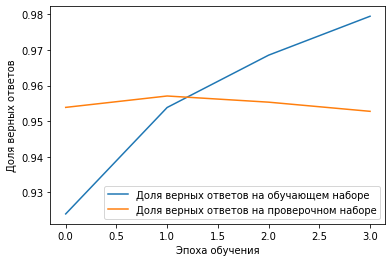

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
test

,Class,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...
...,...,...
37995,1,If I could give 0...I would. Don't do it.
37996,2,Items Selected:\nChocolate Cinnamon Horn\nSmal...
37997,1,Expensive lunch meals. Fried pickles were goo...
37998,1,Highly overpriced and food was cold. Our waitr...


Преобразуем отзывы в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [ ]:
x_test[:5]

Правильные ответы

In [ ]:
y_test = test['Class'] - 1

In [ ]:
y_test

0        1
1        0
2        1
3        0
4        1
        ..
37995    0
37996    1
37997    0
37998    0
37999    0
Name: Class, Length: 38000, dtype: int64

## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 3s 3ms/step - loss: 0.1775 - accuracy: 0.9396


[0.1775321364402771, 0.9396315813064575]

## Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is really bad and very expensive.  The host and waiters are rud. 
I will never visit the SmartBurger again!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
sequence

In [ ]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [ ]:
data

In [ ]:
result = model.predict(data)

In [ ]:
result

In [ ]:
if result < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')


## Задания для самостоятельной работы

Меняйте гиперпараметры нейросети, чтобы повысить качество работы:
  - Длину окна свертки (поробуйте 3, 5, 7 и 9).
  - Количество карт признаков в сверточном слое.
  - Длину вектора представления слов в слое Embedding.
  - Количество сверточных слоев.
  - Количествой нейронов в полносвязном слое для классификации.
  - Параметр Dropout
  - Тип оптимизатора (`adam`, `rmsprop` и др.)
  - Количество эпох обучения.
  - Рармер мини-выборки.

